In [1]:
import QuantLib as ql
import pandas as pd
import numpy as np
import datetime

In [2]:
calendar = ql.UnitedStates()
termstruct_daycount = ql.Thirty360()
today = pd.Timestamp('today')
def dtp2q(pdt):
    return ql.Date(pdt.day, pdt.month, pdt.year)
def dtq2p(qdt):
    return datetime.date(qdt.year(), qdt.month(), qdt.dayOfMonth())

In [3]:
feed = pd.ExcelFile("data.xlsx")
rates = pd.read_excel(feed, sheet_name="Rates")
rates = rates.join(rates.Index.str.extract("(\w+)_([\d]+)(MO|YR)").rename(columns={0: "Family", 1: "Tenor", 2: "Unit"}))
rates.head()

,Index,Rate,Family,Tenor,Unit
0,LIBOR_1MO,0.750,LIBOR,1,MO
1,LIBOR_3MO,1.052,LIBOR,3,MO
2,LIBOR_6MO,0.913,LIBOR,6,MO
3,SWAP_1YR,0.682,SWAP,1,YR
4,SWAP_2YR,0.612,SWAP,2,YR


In [4]:
def leg_helper(r):
    fixedLegFrequency = ql.Annual
    fixedLegTenor = ql.Period(1, ql.Years)
    fixedLegAdjustment = ql.Unadjusted
    fixedLegDayCounter = ql.Thirty360()
    if r.Family == "LIBOR":
        return ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(r.Rate / 100)),
            ql.Period(int(r.Tenor), ql.Months if r.Unit == "MO" else ql.Years),
            2, #settle
            calendar,
            ql.ModifiedFollowing,
            False,
            termstruct_daycount
          )
    else:
        return ql.SwapRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(r.Rate / 100)),
            ql.Period(int(r.Tenor), ql.Months if r.Unit == "MO" else ql.Years),
            calendar,
            fixedLegFrequency,
            fixedLegAdjustment,
            fixedLegDayCounter,
            ql.USDLibor(ql.Period(3, ql.Months)),
        )

In [5]:
curve = ql.PiecewiseCubicZero(2, calendar, rates.apply(leg_helper, axis=1).tolist(), termstruct_daycount)

In [6]:
yts = ql.RelinkableYieldTermStructureHandle(curve)

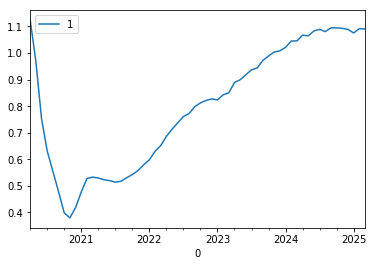

In [7]:
fwds = []
for dt in pd.date_range('2020-04-01', '2025-04-01', freq='1M'):    
    qld = ql.Date(dt.day, dt.month, dt.year)
    rate = yts.forwardRate(qld, calendar.advance(qld, 3, ql.Months), termstruct_daycount, ql.Compounded)
    fwds.append([dt, rate.rate()])
%matplotlib inline
(pd.DataFrame(fwds).set_index(0) * 100).plot()

In [8]:
collat = pd.read_excel(feed, sheet_name="Collat")
collat['Frequency'] = 12 / collat.Tenor

In [9]:
collat['NextPay'] = collat.apply(lambda loan: loan.Maturity - pd.DateOffset(months=((loan.Maturity.to_period('1M') - today.to_period('1M')).n-1) // loan.Tenor * loan.Tenor), axis=1)

In [52]:
class Scenario:
    CallDt = pd.to_datetime("2034-01-01")
    class Reinv:
        Spread = 3.5
        Tenor = 3
        IndexFloor = 1
        Prepay = 20
        Default = 2
        Recovery = 70        
        
class DealInfo:
    ReinvEndDt = pd.to_datetime("2022-01-30")
    CollatCutofDay = 10 # date in month
    NextPayDt = pd.to_datetime("2020-04-30")

In [53]:
def get_loan_cf(loan):
    ppy = 1-(1-loan.Prepay*0.01)**(1/loan.Frequency)
    dflt = 1-(1-loan.Default*0.01)**(1/loan.Frequency)
    ql_schedule = ql.Schedule(
        dtp2q(loan.NextPay),
        dtp2q(loan.Maturity),
        ql.Period(int(loan.Tenor), ql.Months),
        calendar,
        ql.ModifiedFollowing,
        ql.ModifiedFollowing,
        ql.DateGeneration.Backward,
        False
    )
    dates = pd.Series([dtq2p(d) for d in ql_schedule if dtq2p(d) <= Scenario.CallDt])
    cfs = pd.DataFrame({"BalancePre": loan.Balance * np.power((1 - loan.Amort) * (1-ppy) * (1-dflt), np.arange(len(dates))), 'Date': dates})
    cfs['AmortPrin'] = cfs.BalancePre * loan.Amort
    cfs['PrepayPrin'] = (cfs.BalancePre - cfs['AmortPrin']) * ppy
    cfs['DefaultAmt'] = (cfs.BalancePre - cfs['AmortPrin'] - cfs['PrepayPrin']) * dflt
    cfs['BalancePost'] = cfs.BalancePre - cfs.AmortPrin - cfs.PrepayPrin - cfs.DefaultAmt
    rec = (cfs.DefaultAmt * loan.Recovery / 100)
    cfs['RecoveryPrin'] = rec.shift(loan.RecoveryLag).fillna(0)
    cfs.loc[cfs.index[-1], 'RecoveryPrin'] += rec.tail(loan.RecoveryLag).sum()
    cfs['Principal'] = cfs['AmortPrin'] + cfs['PrepayPrin'] + cfs['RecoveryPrin']
    cfs.loc[cfs.index[-1], 'Principal'] += cfs.loc[cfs.index[-1], 'BalancePost']
    
    libor = ql.USDLibor(ql.Period(int(loan.Tenor), ql.Months), yts)
    cfs['IndexRate'] = cfs.Date.apply(lambda d: libor.fixing(libor.fixingDate(dtp2q(d)))).shift(1)
    cfs.loc[cfs.index[0], 'IndexRate'] = libor.fixing(calendar.adjust(dtp2q(today))) # no fixing info. use spot rate for now
    cfs['CouponRate'] = np.maximum(cfs.IndexRate, loan.IndexFloor / 100) + loan.Spread / 100
    cfs['Interest'] = cfs['CouponRate'] * cfs['BalancePre'] * loan.Tenor / 12 # simple compounding
    
    cfs['Name'] = loan.Name
    cfs['Date'] = pd.to_datetime(cfs['Date'])
    return cfs

In [54]:
cf_initial = pd.concat([get_loan_cf(loan)  for _, loan in collat.iterrows()]).set_index('Date')

In [55]:
initial_prin = cf_initial.groupby("Date").sum().Principal

In [56]:
from bintrees import FastRBTree 

In [57]:
tree = FastRBTree(initial_prin.items())

In [58]:
reinv_assets = []
reinv_offset = []
while tree:
    dt, prin = tree.pop_min()
    if dt >= min(DealInfo.ReinvEndDt, Scenario.CallDt):
        break
    reinv_offset.append([dt, prin])
    loan = pd.Series({
        "Name": dt.strftime("Reinv%Y%m%d"),
        "Balance": prin / 0.99 , # px=99
        "Index": "LIBOR_3MO",
        "Spread": 3.5,
        "IndexFloor": 1,
        "Tenor": 3,
        "Maturity": dt + pd.DateOffset(months=60),
        "NextPay": dt + pd.DateOffset(months=3),
        "Amort": 0,
        "Prepay": 20,
        "Default": 2,
        "Recovery": 60,
        "RecoveryLag": 3,
        "Frequency": 4
    })
    reinv_assets.append(loan)
    cfs = get_loan_cf(loan)
    for d, p in cfs[['Date', 'Principal']].values:
        tree.setdefault(d, 0)
        tree[d] += p

In [59]:
reinv_offset = -pd.DataFrame(reinv_offset, columns=['Date', 'Principal']).set_index('Date')

In [60]:
cf_reinv = pd.concat([get_loan_cf(loan) for loan in reinv_assets]).set_index('Date')

In [61]:
cf_collat = pd.concat([cf_initial, cf_reinv, reinv_offset])

In [62]:
nextCutoffDt = datetime.date(DealInfo.NextPayDt.year, DealInfo.NextPayDt.month, DealInfo.CollatCutofDay)
dealCutoffDates = pd.to_datetime([dtq2p(d) for d in     
    ql.Schedule(
        dtp2q(nextCutoffDt) - ql.Period(3, ql.Months),
        dtp2q(nextCutoffDt) + ql.Period(360, ql.Months),
        ql.Period(3, ql.Months),
        calendar,
        ql.Unadjusted,
        ql.Unadjusted,
        ql.DateGeneration.Backward,
        False
    )])
dealPayDates = pd.to_datetime([dtq2p(d) for d in     
    ql.Schedule(
        dtp2q(DealInfo.NextPayDt),
        dtp2q(DealInfo.NextPayDt) + ql.Period(360, ql.Months),
        ql.Period(3, ql.Months),
        calendar,
        ql.ModifiedFollowing,
        ql.ModifiedFollowing,
        ql.DateGeneration.Backward,
        False
    )])

In [63]:
collection_acc = cf_collat.groupby(pd.cut(cf_collat.index, dealCutoffDates)).sum().reset_index()
collection_acc['Date'] = pd.to_datetime(collection_acc['index'].map(lambda x: x.right))
collection_acc.drop(columns="index", inplace=True)
collection_acc.set_index('Date', inplace=True)

In [64]:
cap_struct = pd.read_excel(feed, sheet_name="CapStruct")

In [65]:
libor = ql.USDLibor(ql.Period(int(3), ql.Months), yts)
tranches = cap_struct.copy()
tranches['BalancePost'] = tranches.Balance
liab_cfs = []
for cdate, pdate in zip(dealCutoffDates[1:], dealPayDates):    
    cf = collection_acc.loc[cdate]
    if cf.Principal > 0 or cf.Interest > 0:
        tranches['BalancePre'] = tranches['BalancePost']
        rate = libor.fixing(libor.fixingDate(dtp2q(cdate)))
        tranches['Interest'] = tranches.BalancePre * (rate + tranches.Spread / 100) / 4
        tranches.loc[tranches.index[-1], 'Interest'] = cf.Interest - tranches['Interest'].sum()
        prin = cf.Principal
        bals = tranches['BalancePre'].tolist()
        prins = []
        for i in range(len(bals)):
            paydown = min(bals[i], prin)
            prins.append(paydown)
            bals[i] -= paydown
            prin -= paydown     
        prins[-1] += prin
        tranches['BalancePost'] = bals
        tranches['Principal'] = prins
        tranches['Date'] = pdate
        liab_cfs.append(tranches.copy())

In [66]:
liab_cfs = pd.concat(liab_cfs)

In [67]:
liab_cfs.round()

,Tranche,Balance,Index,Spread,BalancePost,BalancePre,Interest,Principal,Date
0,A,50000000,LIBOR_3MO,1.0,50000000.0,50000000.0,223954.0,-0.0,2020-07-30
1,B,10000000,LIBOR_3MO,4.0,10000000.0,10000000.0,104791.0,0.0,2020-07-30
2,SUBORD,10000000,NaN,NaN,10000000.0,10000000.0,386238.0,0.0,2020-07-30
0,A,50000000,LIBOR_3MO,1.0,50000000.0,50000000.0,191377.0,0.0,2020-10-30
1,B,10000000,LIBOR_3MO,4.0,10000000.0,10000000.0,98275.0,0.0,2020-10-30
...,...,...,...,...,...,...,...,...,...
1,B,10000000,LIBOR_3MO,4.0,0.0,0.0,0.0,0.0,2030-04-30
2,SUBORD,10000000,NaN,NaN,0.0,5160107.0,84662.0,5576811.0,2030-04-30
0,A,50000000,LIBOR_3MO,1.0,0.0,0.0,0.0,0.0,2030-07-30
1,B,10000000,LIBOR_3MO,4.0,0.0,0.0,0.0,0.0,2030-07-30


In [68]:
liab_cfs['Cashflow'] = liab_cfs.Principal + liab_cfs.Interest

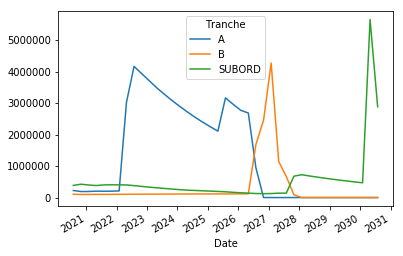

In [75]:
%matplotlib inline
liab_cfs.pivot(index='Date', columns='Tranche', values='Cashflow').plot()